# Approach 1: Warped Input Gaussian Process

(Description here)

In [1]:
# Imports

import gpytorch
import numpy as np
import plotly.graph_objects as go
import torch
from IPython.display import Image
from plotly import subplots
from torch import nn

import utils

image_type = "static"  # html / static

In [2]:
# Load input data

filename_identifier = "A"

# Target data files
filename_true = f"data/true_data_{filename_identifier}.csv"
filename_obs = f"data/observed_data_{filename_identifier}.csv"

# Load as tensors
true_x, true_y, obs_x, obs_y = utils.load_true_and_obs_tensors(
    filename_true,
    filename_obs,
)

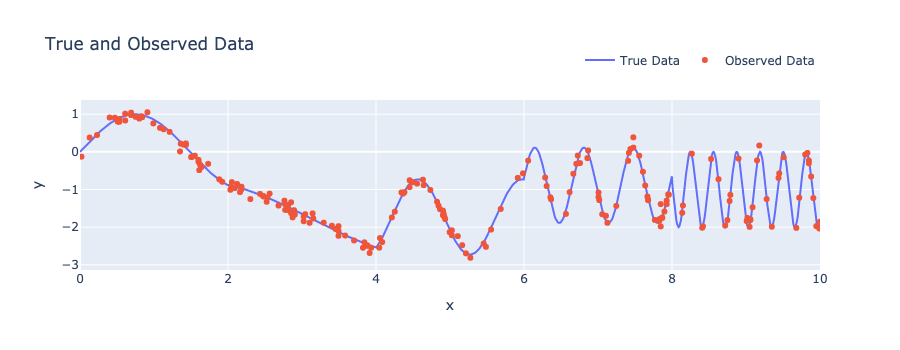

In [3]:
# Plot the data

fig = go.Figure()

# Plot true function and sampled noisy data
fig.add_trace(go.Scatter(x=true_x, y=true_y, mode="lines", name="True Data"))
fig.add_trace(go.Scatter(x=obs_x, y=obs_y, mode="markers", name="Observed Data"))

# Update layout
fig.update_xaxes(range=[0, 10])
fig.update_layout(title="True and Observed Data", xaxis_title="x", yaxis_title="y")
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.15, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))

## Method: Warped Input

In [4]:
# Define the model, likelihood, and additional model components

# Define the warping function
class WarpingFunction(nn.Module):
    """A function that warps the input space. Defined as a neural network with a single hidden layer."""

    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 10), nn.ReLU(), nn.Linear(10, input_dim)
        )

    def forward(self, x):
        return self.net(x)


# Define the Input-Warped GP Model
class WarpedGPModel(gpytorch.models.ExactGP):
    """A GP model that warps the input space. The warping function is defined as a neural network with a single hidden layer."""

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.cov_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.warping_function = WarpingFunction(input_dim=1)

    def forward(self, x):
        warped_x = self.warping_function(x)
        mean_x = self.mean_module(warped_x)
        cov_x = self.cov_module(warped_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x)

In [5]:
# Initialize likelihood and model
train_x, train_y = obs_x.view(-1, 1), obs_y.view(-1)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
warped_model = WarpedGPModel(train_x, train_y, likelihood)

In [6]:
# Train the model

n_epochs = 1000
lr = 0.01

warped_model.train()
likelihood.train()

# Initialize optimizer
optimizer = torch.optim.Adam(warped_model.parameters(), lr=lr)

# Loss function for GP
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, warped_model)

# Training loop
for i in range(n_epochs):
    optimizer.zero_grad()
    output = warped_model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iter {i}: Loss = {loss.item():.3f}")

Iter 0: Loss = 1.231
Iter 10: Loss = 1.015
Iter 20: Loss = 0.996
Iter 30: Loss = 0.975
Iter 40: Loss = 0.954
Iter 50: Loss = 0.929
Iter 60: Loss = 0.897
Iter 70: Loss = 0.861
Iter 80: Loss = 0.833
Iter 90: Loss = 0.808
Iter 100: Loss = 0.781
Iter 110: Loss = 0.754
Iter 120: Loss = 0.728
Iter 130: Loss = 0.706
Iter 140: Loss = 0.685
Iter 150: Loss = 0.667
Iter 160: Loss = 0.651
Iter 170: Loss = 0.638
Iter 180: Loss = 0.626
Iter 190: Loss = 0.615
Iter 200: Loss = 0.605
Iter 210: Loss = 0.596
Iter 220: Loss = 0.586
Iter 230: Loss = 0.574
Iter 240: Loss = 0.560
Iter 250: Loss = 0.451
Iter 260: Loss = 0.391
Iter 270: Loss = 0.299
Iter 280: Loss = 0.210
Iter 290: Loss = 0.117
Iter 300: Loss = 0.057
Iter 310: Loss = -0.014
Iter 320: Loss = -0.059
Iter 330: Loss = -0.106
Iter 340: Loss = -0.123
Iter 350: Loss = -0.167
Iter 360: Loss = -0.195
Iter 370: Loss = -0.221
Iter 380: Loss = -0.243
Iter 390: Loss = -0.259
Iter 400: Loss = -0.274
Iter 410: Loss = -0.286
Iter 420: Loss = -0.295
Iter 430: 

In [7]:
# Evaluate the model

warped_model.eval()
likelihood.eval()

num_posterior_samples = 12

test_x = true_x.view(-1, 1)
with torch.no_grad():
    # Get posterior distribution
    test_preds = warped_model(test_x)
    mean = test_preds.mean
    lower, upper = test_preds.confidence_region()

    # Draw samples from the posterior
    samples = test_preds.sample(sample_shape=torch.Size([num_posterior_samples]))

# Evaluate warping function
warped_x = warped_model.warping_function(test_x).detach().flatten()
warped_y = warped_model.mean_module(warped_x).detach().numpy()

# Warp training data
train_x_warped = warped_model.warping_function(train_x).detach().flatten()
train_y_warped = warped_model.mean_module(train_x_warped).detach().numpy()

# Calculate local scaling factor (gradient of warping function w.r.t. x)
local_scaling_factor = np.gradient(np.abs(warped_x), true_x)


/var/folders/8q/1dg0hln57_xgmstm42jkdxpr0000gn/T/ipykernel_98418/630743772.py:27: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



## Plotting Results

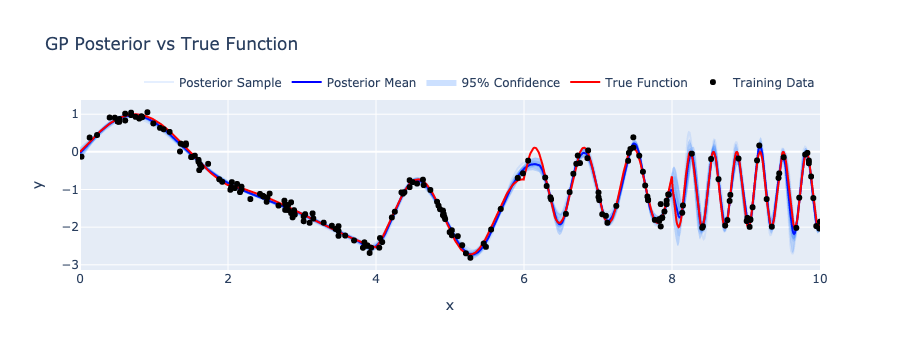

In [8]:
# Plot just the posterior results
fig = go.Figure()

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=samples[i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        )
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x, y=mean, mode="lines", line=dict(color="blue"), name="Posterior Mean"
    )
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
    )
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x, y=true_y, mode="lines", line=dict(color="red"), name="True Function"
    )
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=train_x.view(-1),
        y=train_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
    )
)

# Update layout
fig.update_xaxes(range=[0, 10])
fig.update_layout(
    title="GP Posterior vs True Function", xaxis_title="x", yaxis_title="y"
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))


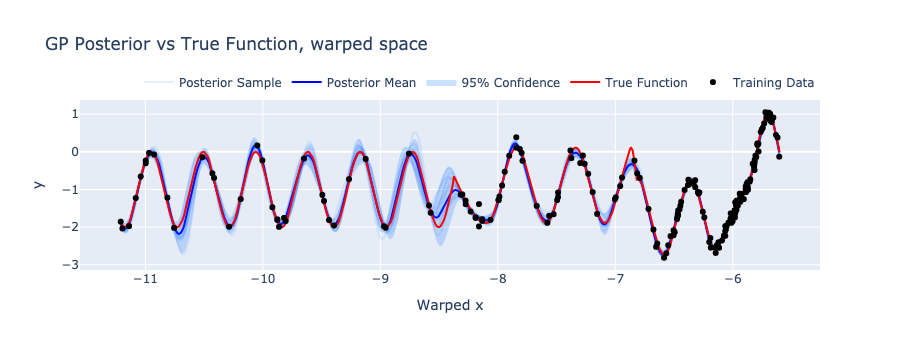

In [9]:
# Plot just the posterior results in warped space
fig = go.Figure()

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=warped_x,
            y=samples[i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        )
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=warped_x,
        y=mean,
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
    )
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([warped_x, warped_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
    )
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=warped_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
    )
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=train_x_warped.view(-1),
        y=train_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
    )
)

# Update layout
fig.update_layout(
    title="GP Posterior vs True Function, warped space",
    xaxis_title="Warped x",
    yaxis_title="y",
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))


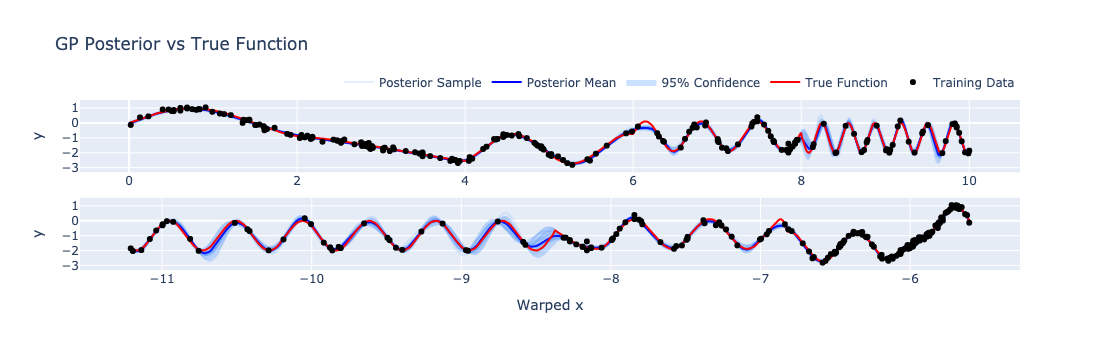

In [10]:
# Plot the posterior results and the warped results
fig = subplots.make_subplots(rows=2, cols=1)

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=samples[i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        ),
        row=1,
        col=1,
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=mean,
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
        legendgroup="posterior_mean",
    ),
    row=1,
    col=1,
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
        legendgroup="confidence_bounds",
    ),
    row=1,
    col=1,
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
        legendgroup="true_function",
    ),
    row=1,
    col=1,
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=train_x.view(-1),
        y=train_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
        legendgroup="training_data",
    ),
    row=1,
    col=1,
)

# Plot the warped results
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=warped_x,
            y=samples[i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=False,
        ),
        row=2,
        col=1,
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=warped_x,
        y=mean,
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
        legendgroup="posterior_mean",
        showlegend=False,
    ),
    row=2,
    col=1,
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([warped_x, warped_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
        legendgroup="confidence_bounds",
        showlegend=False,
    ),
    row=2,
    col=1,
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=warped_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
        legendgroup="true_function",
        showlegend=False,
    ),
    row=2,
    col=1,
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=train_x_warped.view(-1),
        y=train_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
        legendgroup="training_data",
        showlegend=False,
    ),
    row=2,
    col=1,
)

# Update layout
fig.update_layout(title="GP Posterior vs True Function")
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.update_xaxes(title_text="Warped x", row=2, col=1)
fig.update_yaxes(title_text="y", row=1, col=1)
fig.update_yaxes(title_text="y", row=2, col=1)
fig.update_yaxes(title_text="y", row=2, col=1)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=1100, height=350)))

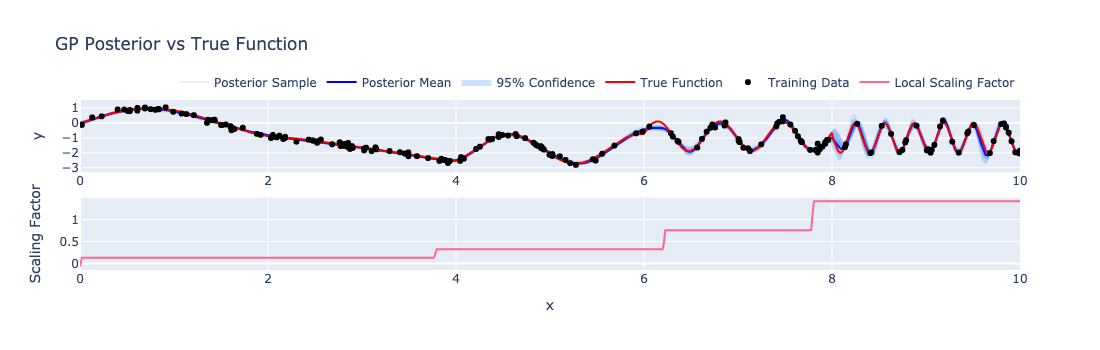

In [11]:
# Plot the posterior results and the local scaling factor
fig = subplots.make_subplots(rows=2, cols=1)

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=samples[i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        ),
        row=1,
        col=1,
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=mean,
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
        legendgroup="posterior_mean",
    ),
    row=1,
    col=1,
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
        legendgroup="confidence_bounds",
    ),
    row=1,
    col=1,
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
        legendgroup="true_function",
    ),
    row=1,
    col=1,
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=train_x.view(-1),
        y=train_y.view(-1),
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
        legendgroup="training_data",
    ),
    row=1,
    col=1,
)

# Plot the local scaling factor
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=local_scaling_factor,
        mode="lines",
        name="Local Scaling Factor",
    ),
    row=2,
    col=1,
)

# Update axes
fig.update_xaxes(range=[0, 10], row=1, col=1)
# fig.update_yaxes(range=[0, 1.75], row=2, col=1)
fig.update_layout(title="GP Posterior vs True Function")
fig.update_xaxes(title_text="x", row=2, col=1)
fig.update_yaxes(title_text="y", row=1, col=1)
fig.update_yaxes(title_text="Scaling Factor", row=2, col=1)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=1100, height=350)))


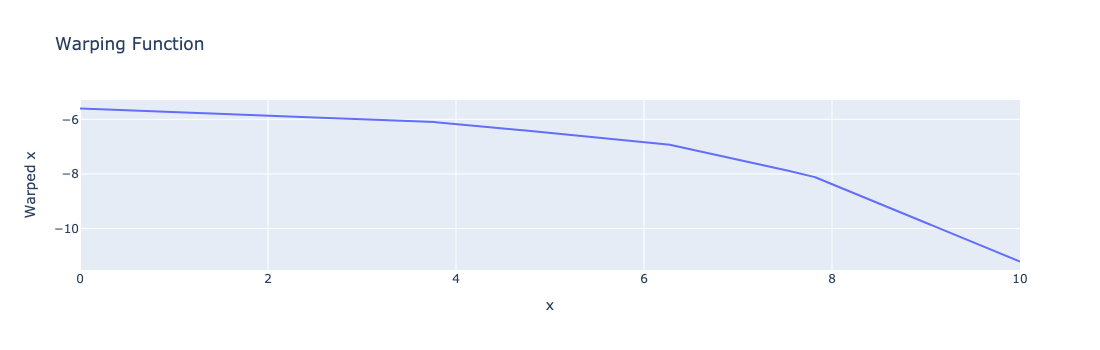

In [12]:
# Plot warping

fig = go.Figure()

fig.add_trace(go.Scatter(x=true_x, y=warped_x, mode="lines", name="Warping Function"))


fig.update_layout(title="Warping Function", xaxis_title="x", yaxis_title="Warped x")

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=1100, height=350)))
